In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import librosa
import os
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

samplerate = 22050  # Sample rate of the audio files
alpha = 0.1 # weight for frequency loss

# load data
audio_path = r'F:\Audio\Audio'
egg_path = r'F:\Audio\EGG'
audio_list = os.listdir(audio_path)
egg_list = os.listdir(egg_path)

class AudioEGGDataset(Dataset):
    def __init__(self, audio_path, egg_path, transform=None):
        self.audio_path = audio_path
        self.egg_path = egg_path
        self.audio_list = os.listdir(audio_path)
        self.egg_list = os.listdir(egg_path)
        self.transform = transform

    def __len__(self):
        return len(self.audio_list)

    def __getitem__(self, idx):
        try:
            audio_file = os.path.join(self.audio_path, self.audio_list[idx])
            egg_file = os.path.join(self.egg_path, self.egg_list[idx])

            # Load audio and EGG data
            audio, sr = librosa.load(audio_file, sr=samplerate)  # None for native sampling rate, or replace with specific rate
            egg, _ = librosa.load(egg_file, sr=samplerate)      # Assume same sample rate as audio

            # Find the maximum length in the dataset or a predetermined max length
            max_length = samplerate * 10  # This could also be dynamically calculated or set based on your data
            # Pad or truncate to the maximum length
            audio = librosa.util.fix_length(audio, size=max_length)
            egg = librosa.util.fix_length(egg, size=max_length)

            if self.transform:
                audio = self.transform(audio)
                egg = self.transform(egg)

            # divide by max value to normalize
            audio = audio / np.max(np.abs(audio))
            egg = egg / np.max(np.abs(egg))

            # Convert to PyTorch tensors and add channel dimension
            audio = torch.from_numpy(audio).float().unsqueeze(0)  # Add channel dimension
            egg = torch.from_numpy(egg).float().unsqueeze(0)

        except Exception as e:
            print(f"Error loading {audio_file} and {egg_file}: {e}")
            return None

        return audio, egg

dataset = AudioEGGDataset(audio_path, egg_path)
# Create train and validation and test sets
batch_size = 4  # Adjust as necessary
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class WaveNet(nn.Module):
    def __init__(self, input_channels, dilation_channels):
        super(WaveNet, self).__init__()
        self.dilation_channels = dilation_channels
        self.receptive_field_size = 1
        self.dilated_convs = nn.ModuleList()

        dilations = [2**i for i in range(6)]
        self.dilated_convs.append(nn.Conv1d(input_channels, 2 * dilation_channels, kernel_size=3, padding=dilations[0]))
        for dilation in dilations[1:]:
            padding = dilation * (3 - 1) // 2
            self.dilated_convs.append(nn.Conv1d(dilation_channels, 2 * dilation_channels, kernel_size=3, padding=padding, dilation=dilation))
            self.receptive_field_size += dilation * 2

        self.output_conv = nn.Conv1d(dilation_channels, 1, kernel_size=1)

    def forward(self, x):
        for conv in self.dilated_convs:
            out = conv(x)
            # Splitting the output of the convolution into filter and gate parts
            filter, gate = torch.split(out, self.dilation_channels, dim=1)  # Correct dimension for splitting is 1 (channels)
            x = torch.tanh(filter) * torch.sigmoid(gate)

        return self.output_conv(x)

# Instantiate the model
channels = 32  # You may need to tune this based on your dataset
model = WaveNet(input_channels=1, dilation_channels=channels)


# cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# loss function to punish spectral 
def to_frequency_domain(signal):
    # Apply the Fast Fourier Transform (FFT)
    fft_signal = torch.fft.fft(signal)
    # Return the magnitude spectrum
    return torch.abs(fft_signal)

def frequency_loss(output, target):
    # Transform both the output and target to the frequency domain
    output_freq = to_frequency_domain(output)
    target_freq = to_frequency_domain(target)
    # Compute the Mean Squared Error in the frequency domain
    freq_loss = F.mse_loss(output_freq, target_freq)
    return freq_loss

def combined_loss(output, target, alpha=0.5):
    # Time-domain MSE
    time_loss = F.mse_loss(output, target)
    # Frequency-domain loss
    freq_loss = frequency_loss(output, target)
    # Combine losses
    combined = (1 - alpha) * time_loss + alpha * freq_loss
    return combined

# criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

checkpoint_dir = 'chkpt'

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, checkpoint_dir='chkpt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.checkpoint_dir = checkpoint_dir

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        dir = os.path.join(self.checkpoint_dir, 'best_checkpoint_early_stop.pt')
        torch.save(model.state_dict(), dir)
        self.val_loss_min = val_loss

In [5]:
def load_checkpoint(model, optimizer, scheduler, filename='checkpoint.pt'):
    """
    Load a model checkpoint.
    """
    start_epoch = 0
    best_loss = float('inf')
    if os.path.isfile(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch'] + 1
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['val_loss']
        print(f"Loaded checkpoint '{filename}' (epoch {checkpoint['epoch']})")
    else:
        print("No checkpoint found at '{filename}'; starting from scratch")
    return model, optimizer,scheduler, start_epoch, best_loss


start_epoch = 0  # Start from the first epoch
chkpt_folder_name = input("Enter the name of the folder to save checkpoints: ")
checkpoint_dir = os.path.join('chkpt', chkpt_folder_name)
os.makedirs(checkpoint_dir, exist_ok=True)
print(f"Checkpoints will be saved in '{checkpoint_dir}'")

early_stopping = EarlyStopping(patience=10, verbose=True, checkpoint_dir=checkpoint_dir)

for epoch in range(start_epoch, 300):  # Adjust the number of epochs based on your needs
    model.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        audio, egg = data
        audio = audio.to(device)
        egg = egg.to(device)

        optimizer.zero_grad()
        output = model(audio)
        loss = combined_loss(output, egg, alpha=alpha) # the larger alpha, the more importance to frequency loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 10 == 0:  # Log every 10 batches
            print(f'Epoch {epoch}, Iteration {i}, Loss: {loss.item()}')

    scheduler.step()

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for data in val_dataloader:
            audio, egg = data
            audio = audio.to(device)
            egg = egg.to(device)
            output = model(audio)
            loss = combined_loss(output, egg, alpha=alpha)
            val_running_loss += loss.item()

    val_loss = val_running_loss / len(val_dataloader)
    print(f'Epoch {epoch}, Validation Loss: {val_loss}')

    # Early stopping and saving best model based on validation loss
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Save checkpoint
    if epoch % 10 == 0:  # Save every 10 epochs in chkpt folder
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{epoch}.pt')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': running_loss / len(dataloader),
            'val_loss': val_loss,
        }, checkpoint_path)

    # Save the best model
    if val_loss < early_stopping.val_loss_min:
        best_model_path = os.path.join(checkpoint_dir, f'WaveNet_best_model_{epoch}.pt')
        torch.save(model.state_dict(), best_model_path)

Checkpoints will be saved in 'chkpt\sr=22050, loss=combine'
Epoch 0, Iteration 0, Loss: 1328.0155029296875
Epoch 0, Iteration 10, Loss: 914.5413208007812
Epoch 0, Iteration 20, Loss: 1427.907470703125
Epoch 0, Iteration 30, Loss: 1439.4290771484375
Epoch 0, Iteration 40, Loss: 2122.424072265625
Epoch 0, Iteration 50, Loss: 1701.7974853515625
Epoch 0, Iteration 60, Loss: 1018.889404296875
Epoch 0, Iteration 70, Loss: 1340.217529296875
Epoch 0, Iteration 80, Loss: 879.2716674804688
Epoch 0, Iteration 90, Loss: 938.8837890625
Epoch 0, Iteration 100, Loss: 1173.0167236328125
Epoch 0, Iteration 110, Loss: 1142.9517822265625
Epoch 0, Iteration 120, Loss: 819.6986083984375
Epoch 0, Iteration 130, Loss: 1058.6707763671875
Epoch 0, Iteration 140, Loss: 794.752197265625
Epoch 0, Iteration 150, Loss: 1055.3499755859375
Epoch 0, Iteration 160, Loss: 828.9202880859375
Epoch 0, Iteration 170, Loss: 1014.0853271484375
Epoch 0, Iteration 180, Loss: 779.31982421875
Epoch 0, Iteration 190, Loss: 798.722

In [6]:
import matplotlib.pyplot as plt

# Load the best model
# model.load_state_dict(torch.load('best_model.pth'))

# Test the model
model.eval()
with torch.no_grad():
    for data in test_dataloader:
        audio, egg = data
        audio = audio.to(device)
        egg = egg.to(device)
        output = model(audio)

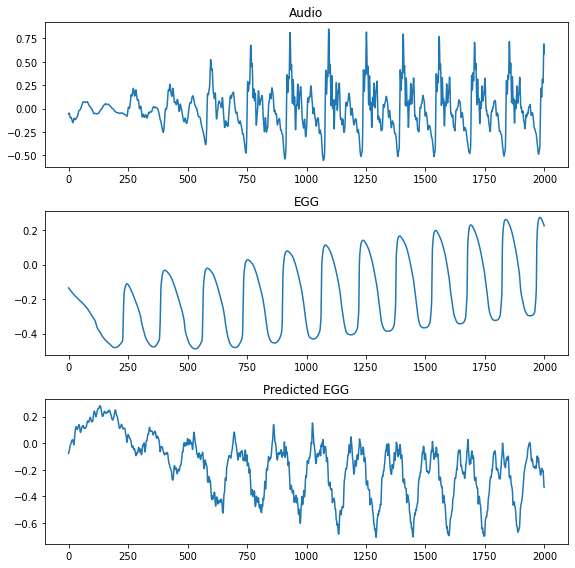

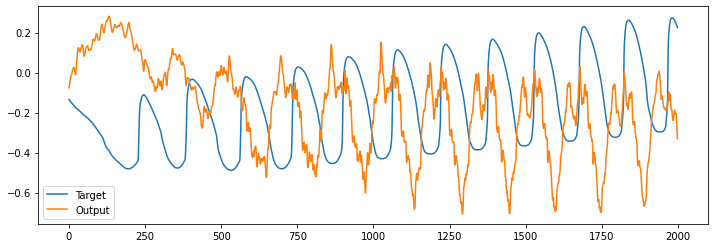

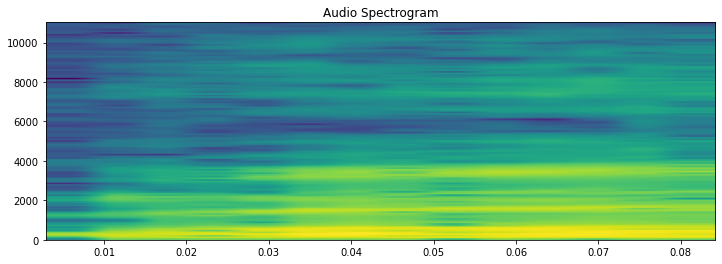

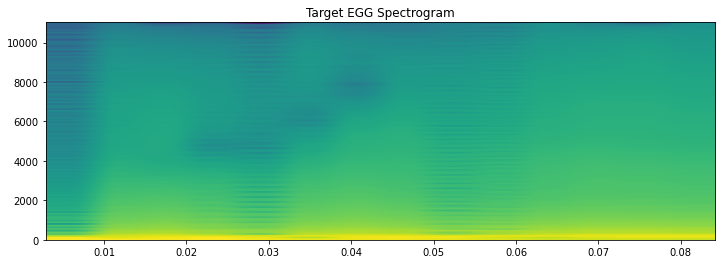

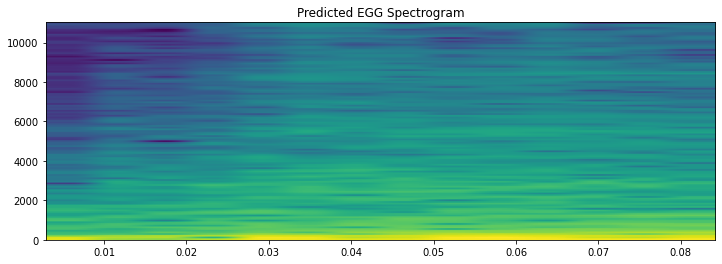

In [13]:

audio_plot = audio[0].cpu().numpy().squeeze()
egg_plot = egg[0].cpu().numpy().squeeze()
output_plot = output[0].cpu().numpy().squeeze()

# select range to plot
start = 22500
end = start + 2000


audio_plot = audio_plot[start:end]
egg_plot = egg_plot[start:end]
output_plot = output_plot[start:end]

# plot the first sample in subplots
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(audio_plot)
plt.title('Audio')
plt.subplot(3, 1, 2)
plt.plot(egg_plot)
plt.title('EGG')
plt.subplot(3, 1, 3)
plt.plot(output_plot)
plt.title('Predicted EGG')
plt.tight_layout()
plt.show()

# plot target and output on top of each other
plt.figure(figsize=(12, 4))
plt.plot(egg_plot, label='Target')
plt.plot(output_plot, label='Output')
plt.legend()
plt.show()

# plot the spectrograms
plt.figure(figsize=(12, 4))
plt.specgram(audio_plot, Fs=samplerate)
plt.title('Audio Spectrogram')
plt.show()

plt.figure(figsize=(12, 4))
plt.specgram(egg_plot, Fs=samplerate)
plt.title('Target EGG Spectrogram')
plt.show()

plt.figure(figsize=(12, 4))
plt.specgram(output_plot, Fs=samplerate)
plt.title('Predicted EGG Spectrogram')
plt.show()


In [ ]:
# save the first predicted EGG as wav
output = output[0]
# save wav in the current folder using soundfile
import soundfile as sf
sf.write('output.wav', output, samplerate)
